# toolkit

In [233]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from keras import Sequential, layers, callbacks
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional


# variables

In [234]:
saved_name = "MANGO_01-01-2010_31-12-2021"

In [235]:
datetime_col = 'SearchDate'
target_column = 'DEMA_RetailPrice_100'

In [236]:
n_look_back = 180
n_units = 64

# helper-class

In [237]:
class GRU_helper():

    def __init__(self, saved_name, datetime_col, target_column):
        self.datetime_col = datetime_col
        self.target_column = target_column

        self.train_df, self.validate_df = self._import_data(saved_name, datetime_col)
    

    def transform(self, look_back):
        train_scaled, y_validate = self._processor()
        X_train, y_train = self._create_input(train_scaled, look_back)

        return X_train, y_train, y_validate
    
    
    def create_gru(self, units, X_train_shape):
        model = Sequential()

        # Input layer
        model.add(
            GRU (
                units = units, 
                return_sequences = True, 
                input_shape = [X_train_shape[1], X_train_shape[2]]
            )
        )
        model.add(Dropout(0.2))

        # Hidden layer
        model.add(GRU(units = units))
        model.add(Dropout(0.2))
        model.add(Dense(units = 1))

        # optimizer declaration
        opt = keras.optimizers.Adam(learning_rate = 0.001)

        #Compile model
        model.compile(optimizer = opt ,loss = 'mse')
        return model
    

    def fit_model(self, model, X_train, y_train):
        early_stop = keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            patience = 10
        )

        history = model.fit(
            X_train, y_train, 
            epochs = 50, 
            validation_split = 0.2, 
            batch_size = 16, 
            shuffle = False, 
            callbacks = [early_stop]
        )

        return history
    

    def plot_fitting (self, history, model_name):
        plt.figure(figsize = (10, 6))
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Train vs Validation Loss for ' + model_name)
        plt.ylabel('Loss')
        plt.xlabel('epoch')
        plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    

    def forecast(self, model, X_train, pred_length):
        history = np.array([X_train[-1]])
        forecasts = []

        for _ in range(pred_length):
            output = model.predict(history)
            
            yhat = output
            forecasts.append(list(self.scaler.inverse_transform(yhat)[0]))

            history = np.append(history, [yhat], axis = 1)
            history = np.delete(history, 0, axis = 1)

        return forecasts


    def rescale_y_vals(self, y_train, y_validate):
        y_train = self.scaler.inverse_transform(y_train)
        y_validate = self.scaler.inverse_transform(y_validate)

        return y_train, y_validate


    def plot_future(self, prediction, model_name, y_test, y_train):
        plt.figure(figsize=(20, 5))
        range_future = len(prediction)

        plt.plot(np.arange(len(y_train)), np.array(y_train), 
                label='Train   data')
        plt.plot(np.arange(len(y_train) + 1, len(y_train) + 1 + range_future), 
                np.array(y_test), label='Test   data')
        plt.plot(np.arange(len(y_train) + 1, len(y_train) + 1 + range_future), 
                np.array(prediction),label='Prediction')
        
        plt.title('Test data vs prediction for ' + model_name)
        plt.legend()
        plt.show()
    

    def evaluate_prediction(self, predictions, actual, model_name):
        errors = predictions - actual
        mse = np.square(errors).mean()
        rmse = np.sqrt(mse)
        mae = np.abs(errors).mean()
        mape = np.abs(errors / actual).mean()
        print(model_name + ':')
        print('Mean Absolute Error: {:.4f}'.format(mae))
        print('Root Mean Square Error: {:.4f}'.format(rmse))
        print('Mean Absolute Percentage Error: {:.4f}'.format(mape))
        print('')


    #---------------------------------------------------
    # PRIVATE FUNCTIONS
    #---------------------------------------------------
    def _import_data(self, saved_name, datetime_col):
        train_df = pd.read_csv("./processed_data/train/" + saved_name + ".csv", parse_dates = [datetime_col])
        validate_df = pd.read_csv("./processed_data/validate/" + saved_name + ".csv", parse_dates = [datetime_col])
        
        return train_df, validate_df
    
    
    def _processor(self):
        train_data = self.train_df[[self.target_column]]
        validate_data = self.validate_df[[self.target_column]]
        
        self.scaler = StandardScaler().fit(train_data)

        train_scaled = self.scaler.transform(train_data)
        validate_scaled = self.scaler.transform(validate_data)

        return train_scaled, validate_scaled
    

    def _create_input(self, X, look_back = 1):
        Xs, ys = [], []
    
        for i in range(len(X)-look_back):
            v = X[i:i+look_back]
            Xs.append(v)
            ys.append(X[i+look_back])
    
        return np.array(Xs), np.array(ys)

# implementation

In [238]:
gru_helper = GRU_helper(saved_name, datetime_col, target_column)

In [239]:
X_train, y_train, y_validate = gru_helper.transform(n_look_back)

In [240]:
gru_model = gru_helper.create_gru(n_units, X_train.shape)

gru_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_28 (GRU)                (None, 180, 64)           12864     
                                                                 
 dropout_28 (Dropout)        (None, 180, 64)           0         
                                                                 
 gru_29 (GRU)                (None, 64)                24960     
                                                                 
 dropout_29 (Dropout)        (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 37,889
Trainable params: 37,889
Non-trainable params: 0
_________________________________________________________________


In [241]:
gru_model_name = 'GRU_' + str(n_units) + '_' + str(n_look_back)

In [242]:
fitting_history = gru_helper.fit_model(gru_model, X_train, y_train)

Epoch 1/50
177/177 [==============================] - 13s 62ms/step - loss: 0.0311 - val_loss: 0.1627
Epoch 2/50
177/177 [==============================] - 10s 55ms/step - loss: 0.0404 - val_loss: 0.1141
Epoch 3/50
177/177 [==============================] - 10s 55ms/step - loss: 0.0389 - val_loss: 0.0368
Epoch 4/50
177/177 [==============================] - 10s 54ms/step - loss: 0.0240 - val_loss: 0.0216
Epoch 5/50
177/177 [==============================] - 10s 54ms/step - loss: 0.0197 - val_loss: 0.0295
Epoch 6/50
177/177 [==============================] - 10s 54ms/step - loss: 0.0181 - val_loss: 0.0291
Epoch 7/50
177/177 [==============================] - 9s 54ms/step - loss: 0.0193 - val_loss: 0.0568
Epoch 8/50
177/177 [==============================] - 9s 54ms/step - loss: 0.0239 - val_loss: 0.0358
Epoch 9/50
177/177 [==============================] - 10s 54ms/step - loss: 0.0201 - val_loss: 0.0514
Epoch 10/50
177/177 [==============================] - 9s 54ms/step - loss: 0.0221 -

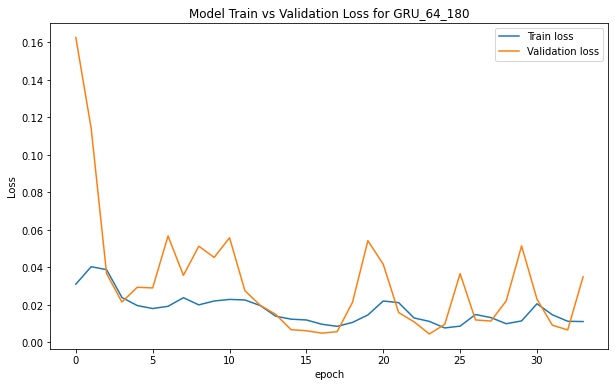

In [243]:
gru_helper.plot_fitting(fitting_history, gru_model_name)

In [244]:
y_pred = gru_model.predict(X_train)

111/111 [==============================] - 2s 18ms/step


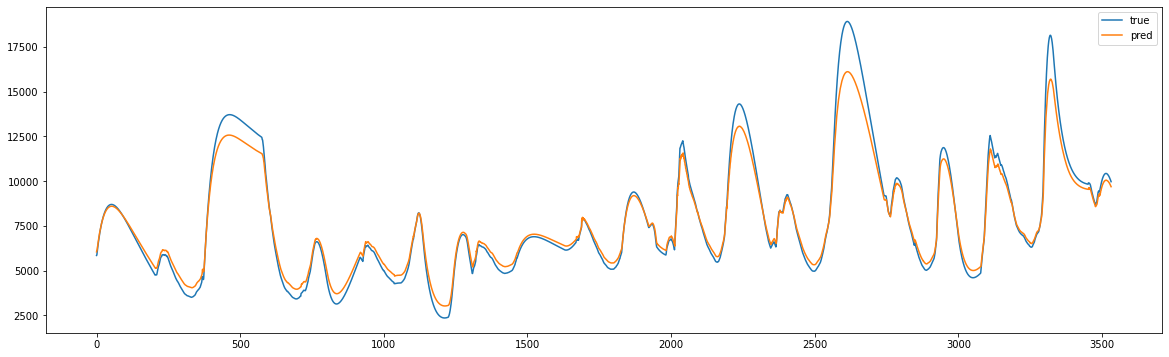

In [245]:
plt.figure(figsize=(20, 6))

plt.plot(gru_helper.scaler.inverse_transform(y_train), label = 'true')
plt.plot(gru_helper.scaler.inverse_transform(y_pred), label = 'pred')

plt.legend()
plt.show()

In [246]:
gru_forecast = gru_helper.forecast(gru_model, X_train, len(y_validate))

1/1 [==============================] - 0s 17ms/step


In [247]:
y_train, y_validate = gru_helper.rescale_y_vals(y_train, y_validate)

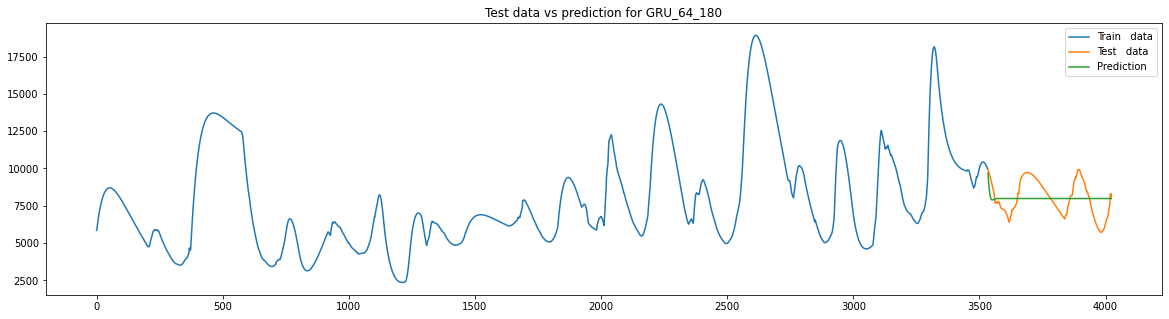

In [248]:
gru_helper.plot_future(gru_forecast, gru_model_name, y_validate, y_train)

In [249]:
gru_helper.evaluate_prediction(gru_forecast, y_validate, gru_model_name)

GRU_64_180:
Mean Absolute Error: 1002.3821
Root Mean Square Error: 1163.2905
Mean Absolute Percentage Error: 0.1293

